In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

from IPython.display import display

import seaborn as sns
sns.set_theme()

from utils import *

In [2]:
results_orginal = pd.read_csv("../results_gathering/results_table.csv")
results_orginal.head()

,pred_text,pred_text_len,pred_x,pred_y,pred_x1,pred_x2,pred_y1,pred_y2,pred_width,pred_hight,...,iou,labels_file_name,detections_file_name,recognition_file_name,image_name,image_width,image_height,dataset,model,weights
0,-,-,-,-,-,-,-,-,-,-,...,0.0,gt_img_1.txt,detection_res_img_1.txt,recognition_res_img_1.txt,img_1.jpg,1280,720,ic15,db,tt
1,-,-,-,-,-,-,-,-,-,-,...,0.0,gt_img_1.txt,detection_res_img_1.txt,recognition_res_img_1.txt,img_1.jpg,1280,720,ic15,db,tt
2,-,-,-,-,-,-,-,-,-,-,...,0.0,gt_img_1.txt,detection_res_img_1.txt,recognition_res_img_1.txt,img_1.jpg,1280,720,ic15,db,tt
3,-,-,-,-,-,-,-,-,-,-,...,0.0,gt_img_1.txt,detection_res_img_1.txt,recognition_res_img_1.txt,img_1.jpg,1280,720,ic15,db,tt
4,-,-,-,-,-,-,-,-,-,-,...,0.0,gt_img_1.txt,detection_res_img_1.txt,recognition_res_img_1.txt,img_1.jpg,1280,720,ic15,db,tt


In [3]:
results_orginal.columns

Index(['pred_text', 'pred_text_len', 'pred_x', 'pred_y', 'pred_x1', 'pred_x2',
       'pred_y1', 'pred_y2', 'pred_width', 'pred_hight', 'text', 'text_len',
       'x', 'y', 'x1', 'x2', 'y1', 'y2', 'width', 'hight', 'detection_status',
       'recogniton_status', 'redable_label', 'iou', 'labels_file_name',
       'detections_file_name', 'recognition_file_name', 'image_name',
       'image_width', 'image_height', 'dataset', 'model', 'weights'],
      dtype='object')

In [4]:
# Remove non readable examples
print(f"Len of results table with all examples: {len(results_orginal)}")
results_orginal = results_orginal[results_orginal.redable_label == True]
print(f"Len of results table without non readable examples: {len(results_orginal)}")

Len of results table with all examples: 38334
Len of results table without non readable examples: 24389


In [5]:
path =  "./resolution_plots"
kategoria = "Rozdzielczość"

In [6]:
## Create resolution column
results_orginal['resolution'] =results_orginal['image_width'].astype(str) + 'x' + results_orginal['image_height'].astype(str)

In [7]:
images = results_orginal.groupby("image_name")[['image_width', 'image_height', 'dataset', 'resolution']].first()

In [8]:
images.dataset.value_counts()

ic15    497
tt      299
ic03    247
Name: dataset, dtype: int64

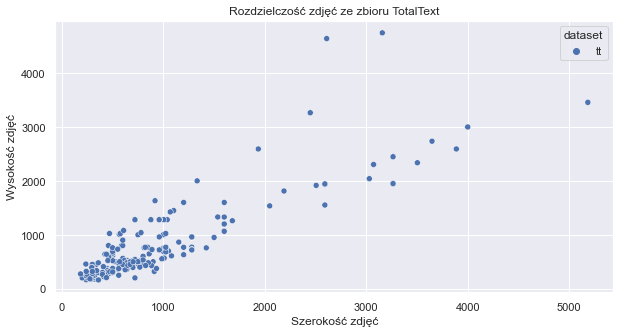

In [9]:
fig, ax = plt.subplots( figsize=(10, 5))
sns.scatterplot(data=images[images.dataset=='tt'], x='image_width', y='image_height', hue='dataset', ax=ax)
ax.set_title("Rozdzielczość zdjęć ze zbioru TotalText")
ax.set_xlabel("Szerokość zdjęć")
ax.set_ylabel("Wysokość zdjęć")
fig.savefig(f"{path}/resolution_distribution.png")

In [10]:
split_conditions = {
    "Niska": (0, 500),
    "Średnia": (500, 1000),
    "Wysoka": (1000, 2000),
    "Bardzo wysoka":(2000, np.inf)
}
images_names = {}
for key, value in split_conditions.items():
    imgs = list(images[(images.dataset=='tt') & (images.image_width.between(*value, inclusive="left"))
                       & (images.image_height.between(*value, inclusive="left"))].index)
    images_names[key] = imgs    
    print(len(imgs))

69
59
18
19


In [11]:
dfs = []
for key, imgs in images_names.items():
#     imgs = random.sample(imgs, 27)
    df_temp = results_orginal[results_orginal.image_name.isin(imgs)]
    df_temp['Rozdzielczość'] = key
    dfs.append(df_temp)
    print(df_temp.shape)
finaldf = pd.concat(dfs)

(1879, 35)
(2059, 35)
(755, 35)
(602, 35)


<ipython-input-11-24604814baab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Rozdzielczość'] = key


In [12]:
finaldf.image_name.nunique()

164

In [13]:
finaldf['Rozdzielczość'].value_counts()

Średnia          2059
Niska            1879
Wysoka            755
Bardzo wysoka     602
Name: Rozdzielczość, dtype: int64

## Detection results analysis

In [14]:
results = finaldf

In [15]:
split_column = 'Rozdzielczość'

In [16]:
models_list = list(results.model.unique())
weights_list = list(results.weights.unique())

In [17]:
models_list.sort()
models_list

['db', 'textfusenet']

In [18]:
categories = list(pd.unique(results[split_column]))
# categories.sort()
print(categories)

['Niska', 'Średnia', 'Wysoka', 'Bardzo wysoka']


In [19]:
detection_metrics = {}

for category in categories:
     
    df = results[results[split_column] == category]
    detection_metrics[category] = detection_metrics_to_df(df, models_list, weights_list)


In [20]:
for key, value in detection_metrics.items():
    print(key)
    
    display(value)

Niska


,system,precyzja,pełność,f1
0,System z modelem db wytrenowany na zbiorze tt,76.25,56.86,65.14
1,System z modelem db wytrenowany na zbiorze ic15,68.00,59.35,63.38
2,System z modelem textfusenet wytrenowany na zb...,87.16,72.82,79.35
3,System z modelem textfusenet wytrenowany na zb...,85.67,73.07,78.87


Średnia


,system,precyzja,pełność,f1
0,System z modelem db wytrenowany na zbiorze tt,74.33,62.61,67.97
1,System z modelem db wytrenowany na zbiorze ic15,68.75,61.94,65.17
2,System z modelem textfusenet wytrenowany na zb...,91.40,57.43,70.54
3,System z modelem textfusenet wytrenowany na zb...,88.20,63.96,74.15


Wysoka


,system,precyzja,pełność,f1
0,System z modelem db wytrenowany na zbiorze tt,79.53,62.35,69.90
1,System z modelem db wytrenowany na zbiorze ic15,63.86,65.43,64.64
2,System z modelem textfusenet wytrenowany na zb...,86.75,44.44,58.77
3,System z modelem textfusenet wytrenowany na zb...,89.36,51.85,65.62


Bardzo wysoka


,system,precyzja,pełność,f1
0,System z modelem db wytrenowany na zbiorze tt,64.76,56.67,60.45
1,System z modelem db wytrenowany na zbiorze ic15,51.24,51.67,51.45
2,System z modelem textfusenet wytrenowany na zb...,84.34,58.33,68.96
3,System z modelem textfusenet wytrenowany na zb...,85.06,61.67,71.50


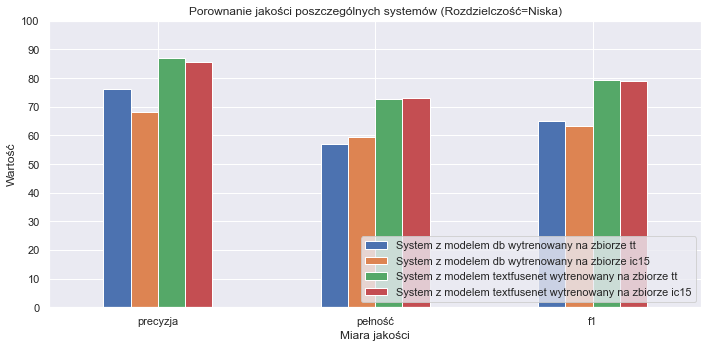

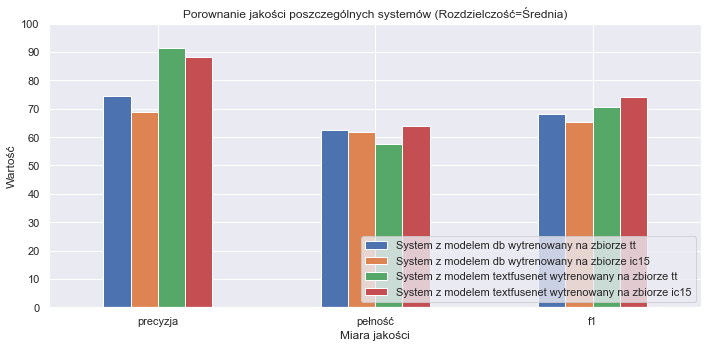

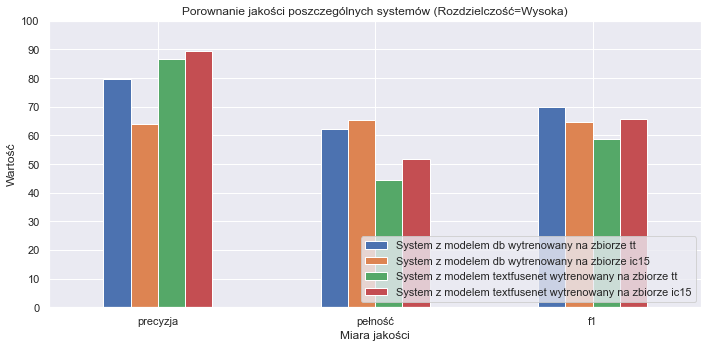

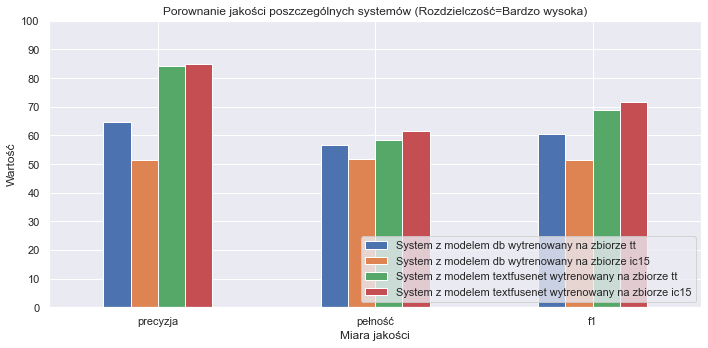

In [21]:
for key, value in detection_metrics.items():
    plot_detection_metrics(value, f"{path}/{key}_detection_metrics.png",
                          title = f"Porownanie jakości poszczególnych systemów ({kategoria}={key})")

## Plot metrics across split category

In [22]:
import seaborn as sns

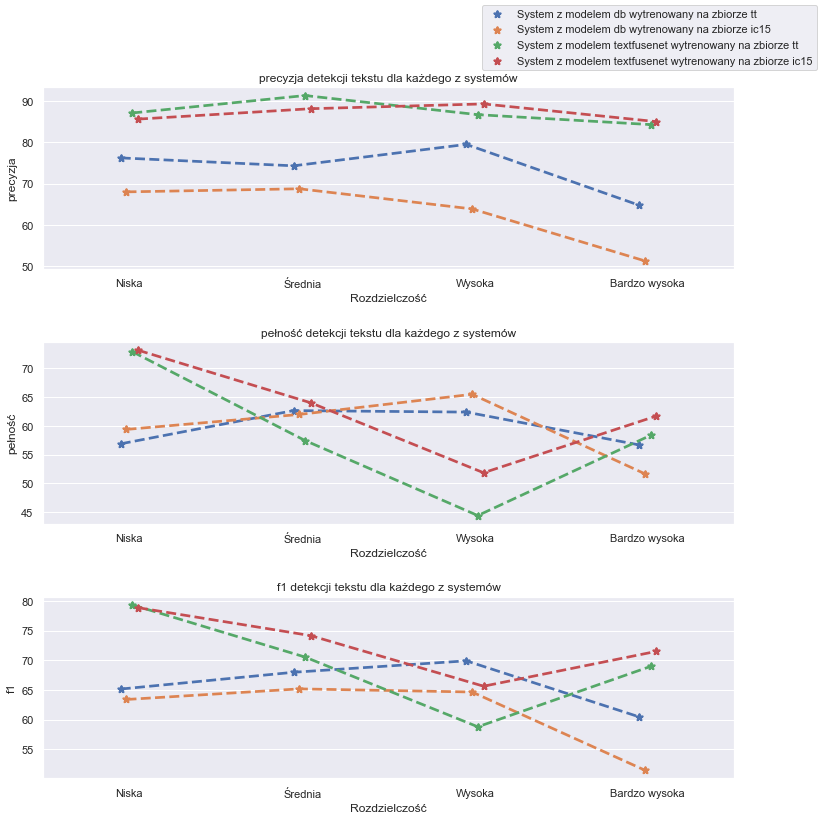

In [23]:
plot_detection_metrics_in_one(detection_metrics, filename=f"{path}/detections_metrics_subplot.jpg", category='Rozdzielczość', figsize=(12, 12))

### plot detections of each system on random image from totaltext dataset

In [24]:
results.dataset.unique()

array(['tt'], dtype=object)

In [25]:
categories

['Niska', 'Średnia', 'Wysoka', 'Bardzo wysoka']

Niska


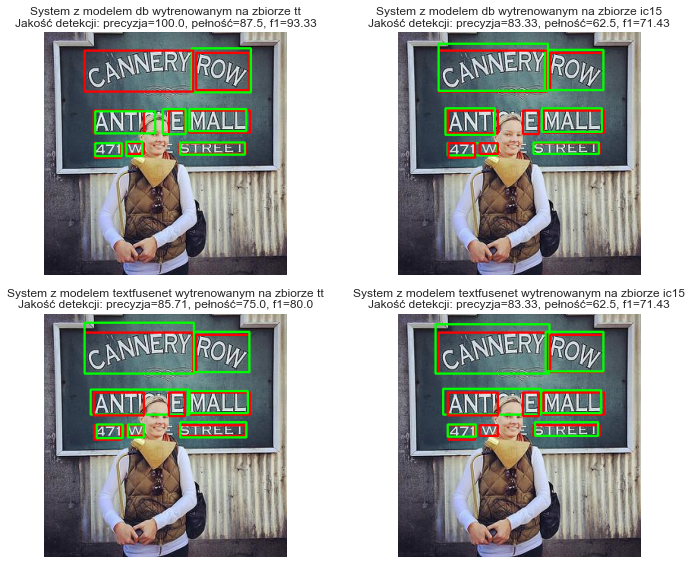

In [26]:
for category in categories:
    
    print(category)
    df = results[results[split_column] == category]
    plot_detections(df, models_list, weights_list, filename=f"{path}/{category}_detections.jpg")
    break

## Recognition results analysis

In [27]:
recognition_metrics = {}

for category in categories:
     
    df = results[results[split_column] == category]
    recognition_metrics[category] = recognition_metrics_to_df(df, models_list, weights_list)

In [28]:
for key, value in recognition_metrics.items():
    print(key)
    
    display(value)

Niska


,system,dokładność na poprawnych detekcjach,dokładność ogólnie
0,System z modelem db z wagami tt,80.70,45.89
1,System z modelem db z wagami ic15,79.41,47.13
2,System z modelem textfusenet z wagami tt,75.34,54.86
3,System z modelem textfusenet z wagami ic15,73.38,53.62


Średnia


,system,dokładność na poprawnych detekcjach,dokładność ogólnie
0,System z modelem db z wagami tt,78.42,49.10
1,System z modelem db z wagami ic15,77.45,47.97
2,System z modelem textfusenet z wagami tt,64.31,36.94
3,System z modelem textfusenet z wagami ic15,67.96,43.47


Wysoka


,system,dokładność na poprawnych detekcjach,dokładność ogólnie
0,System z modelem db z wagami tt,72.28,45.06
1,System z modelem db z wagami ic15,75.47,49.38
2,System z modelem textfusenet z wagami tt,59.72,26.54
3,System z modelem textfusenet z wagami ic15,71.43,37.04


Bardzo wysoka


,system,dokładność na poprawnych detekcjach,dokładność ogólnie
0,System z modelem db z wagami tt,73.53,41.67
1,System z modelem db z wagami ic15,70.97,36.67
2,System z modelem textfusenet z wagami tt,51.43,30.00
3,System z modelem textfusenet z wagami ic15,55.41,34.17


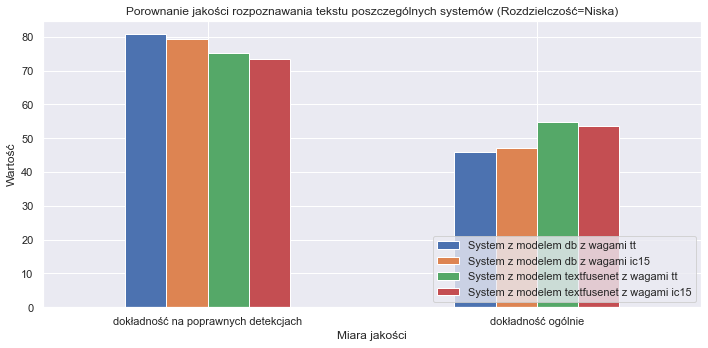

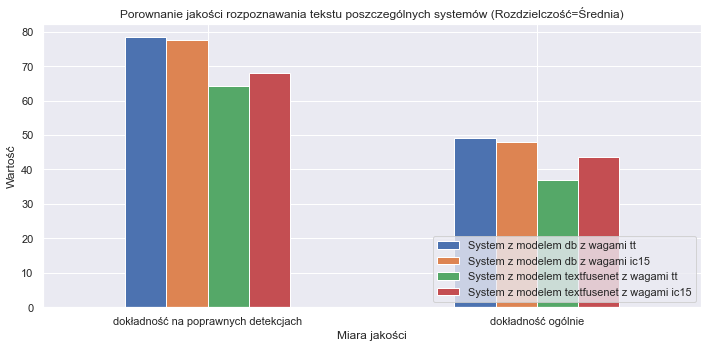

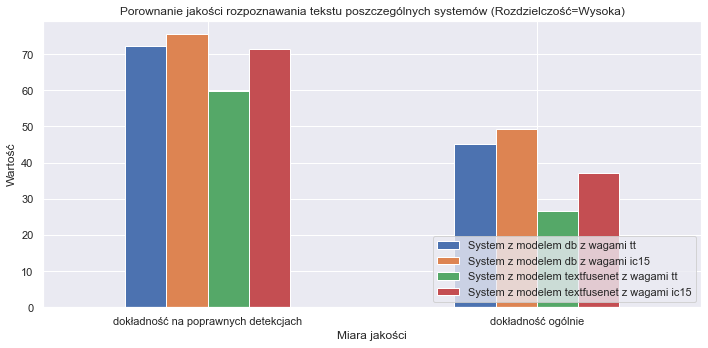

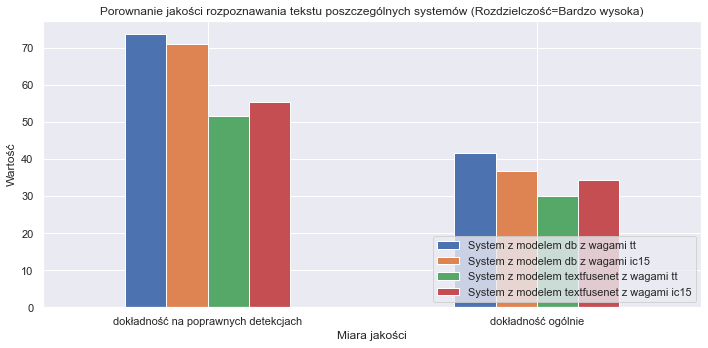

In [29]:
for key, value in recognition_metrics.items():
    print
    plot_recognition_metrics(value, f"{path}/{key}_recognition_metrics.png",
                          title = f"Porownanie jakości rozpoznawania tekstu poszczególnych systemów ({kategoria}={key})")

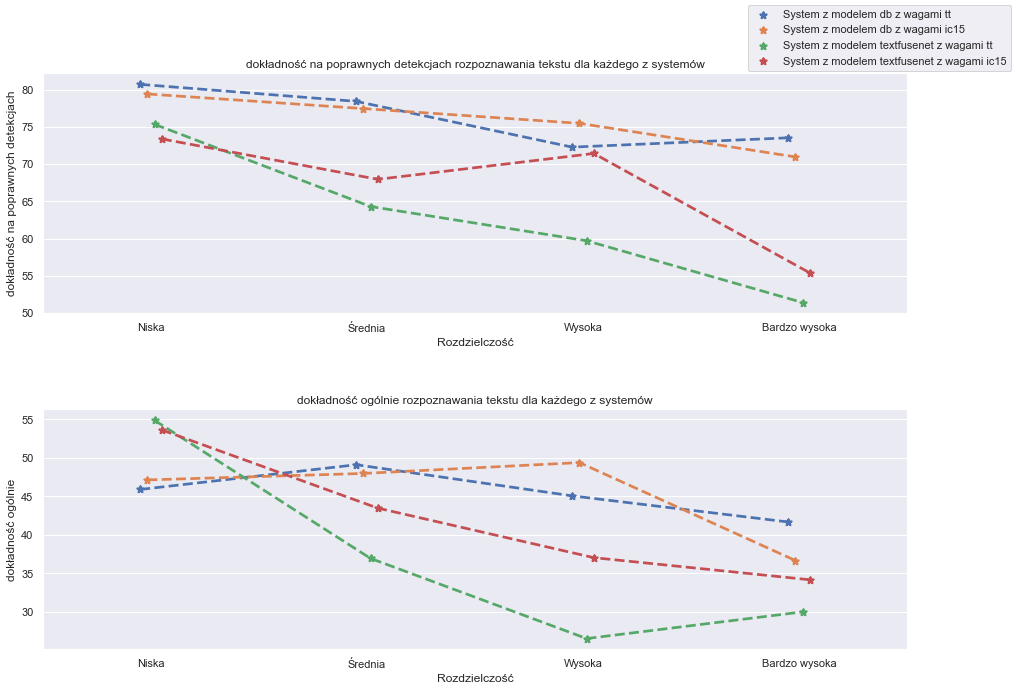

In [30]:
plot_recognition_metrics_in_one(recognition_metrics,
                              filename=f"{path}/recognitions_metrics_subplot.jpg",
                               category='Rozdzielczość')

In [31]:
for category in categories:
    
    print(category)
    df = results[results[split_column] == category]
    plot_iou_histogram(df, models_list, weights_list, filename=f"{path}/{category}_iou_histograms.jpg")

Niska


ValueError: (15, 10) is not a valid value for sharex; supported values are 'all', 'row', 'col', 'none'

<Figure size 432x288 with 0 Axes>

### Recognition example

In [ ]:
for category in categories:
    
    print(category)
    df = results[results[split_column] == category]
    plot_recognitions(df, models_list, weights_list, filename=f"{path}/{category}_recognitions.jpg")